### Домашнее задание "Модели ARIMA"
Выберите ряд из первого задания и постройте его модель ARIMA. Отчет нужно будет оформить в jupyter-ноутбук.  
Дополнительное задание: попробуйте спрогнозировать график классическим ML.  

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline

from warnings import filterwarnings 
filterwarnings('ignore')

In [16]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [17]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

**ARIMA (p,d,q)**  
Попробуем применить ARIMA к врменному ряду и сделать предсказание.

In [26]:
series = pd.read_csv("1_time_series/Series/weekly-closings-of-the-dowjones-.csv")["Close"]

aic: 1416.27670 | order: (2, 2, 3)
Results of Dickey-Fuller Test:
Test Statistic                -1.184571e+01
p-value                        7.408198e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.590000e+02
Critical Value (1%)           -3.472161e+00
Critical Value (5%)           -2.879895e+00
Critical Value (10%)          -2.576557e+00
dtype: float64


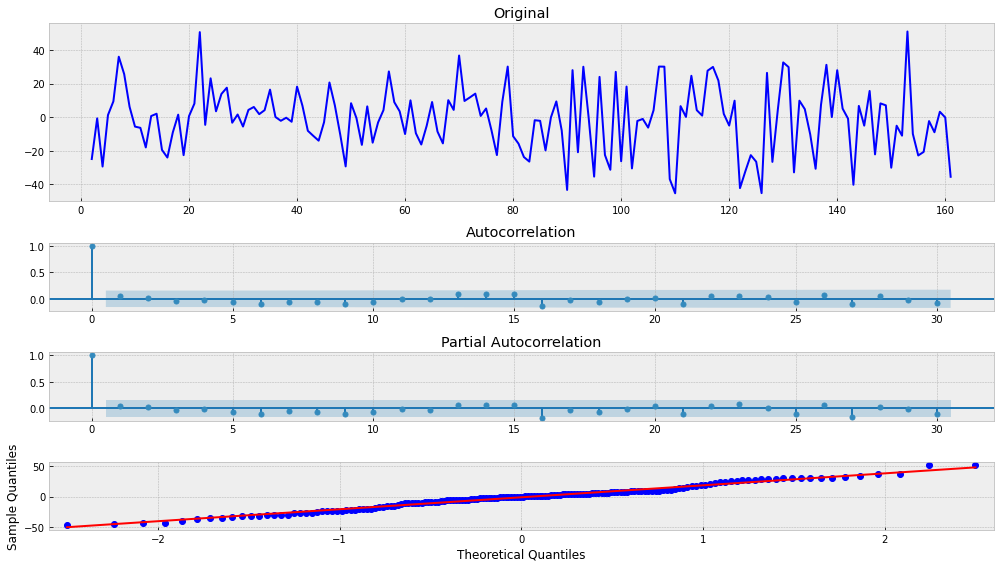

In [27]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

In [28]:
print(best_mdl.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  160
Model:                 ARIMA(2, 2, 3)   Log Likelihood                -702.138
Method:                           mle   S.D. of innovations             19.208
Date:                Tue, 22 Feb 2022   AIC                           1416.277
Time:                        23:43:10   BIC                           1434.728
Sample:                             2   HQIC                          1423.769
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
ar.L1.D2.Close    -1.5987      0.051    -31.043      0.000      -1.700      -1.498
ar.L2.D2.Close    -0.9299      0.059    -15.824      0.000      -1.045      -0.815
ma.L1.D2.Close     0.5837      0.079

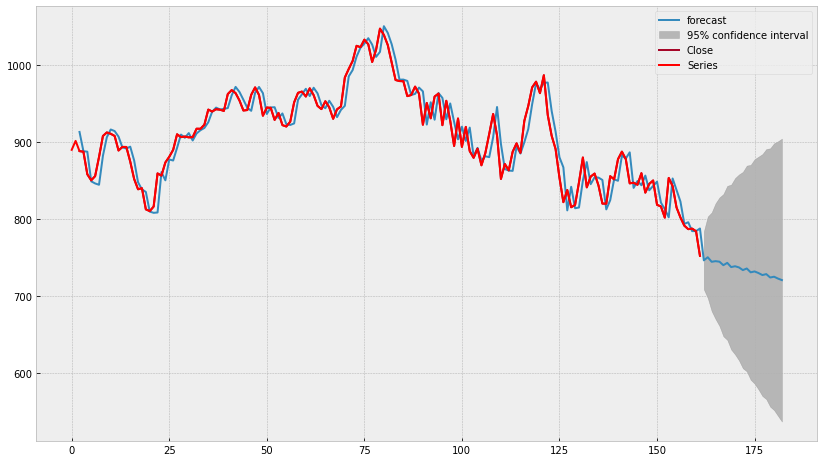

In [29]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(2, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

Теперь приведем ряд к стационарности, применим ARIMA и вновь попробуем сделать предсказание.

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


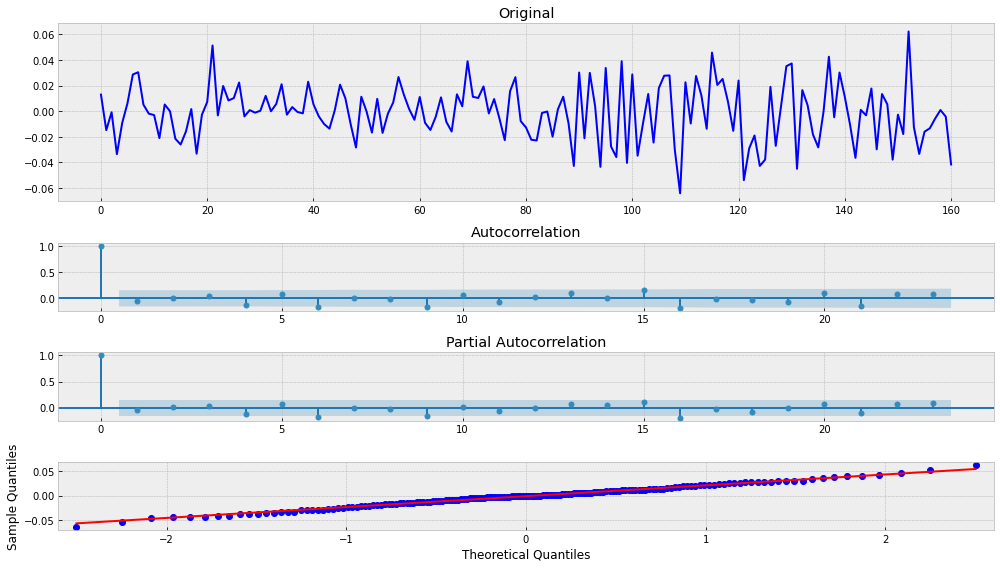

In [30]:
# Нормализуем дисперсию
series_st = boxcox(series, 0)
# дифференцируем
series_st = np.diff(series_st, 1)
# тест ДФ
# кореллограмма
tsplot(series_st)

aic: -770.01581 | order: (2, 0, 2)
Results of Dickey-Fuller Test:
Test Statistic                -1.183715e+01
p-value                        7.742401e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


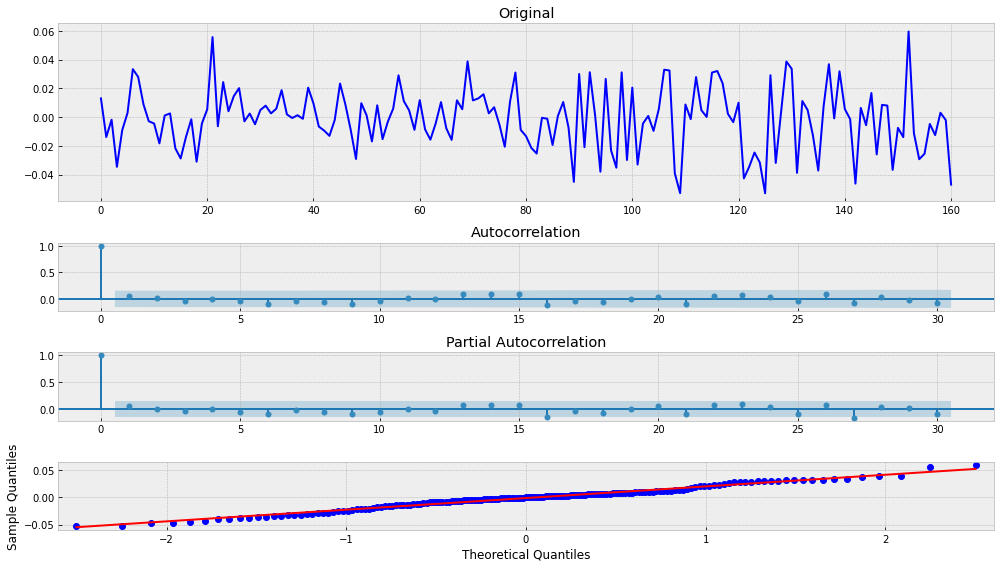

In [31]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series_st, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

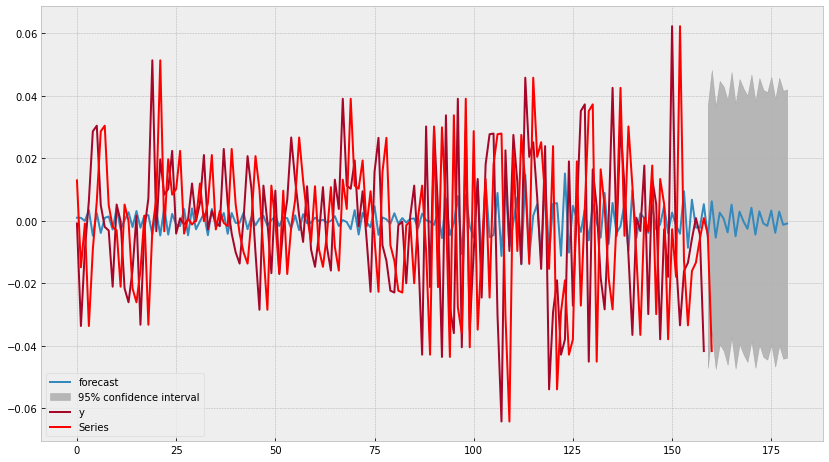

In [32]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(2, len(series_st)+20, ax=ax)
    plt.plot(series_st, color='red', label='Series')
    plt.legend()
    plt.show()